In [ ]:
# installing libraries for sound processing

!pip install librosa
!pip install iPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 8.9 MB/s 


In [ ]:
import numpy as np
import cv2

# ---libraries for sound processing
import librosa
import librosa.display
import IPython
#---

# ---libraries for neural networks
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Dropout
import tensorflow as tf
#---

import time
import struct
import os
from glob import glob
import random
import sklearn
from sklearn import metrics

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Noise filtering with FFT

In [ ]:
np.random.seed(1) # fixing random state

### Synthetic signal creating

In [ ]:
dt = 0.002
t = np.arange(0, 1, dt)

signal = np.sin(2 * np.pi * 50 * t) + np.sin(2 * np.pi * 120 * t) # our signal is created by summing two sine functions different frequencies (50Hz and 120Hz).

noisy_signal = signal + 3 * np.random.randn(len(t)) # adding random noise to our signal

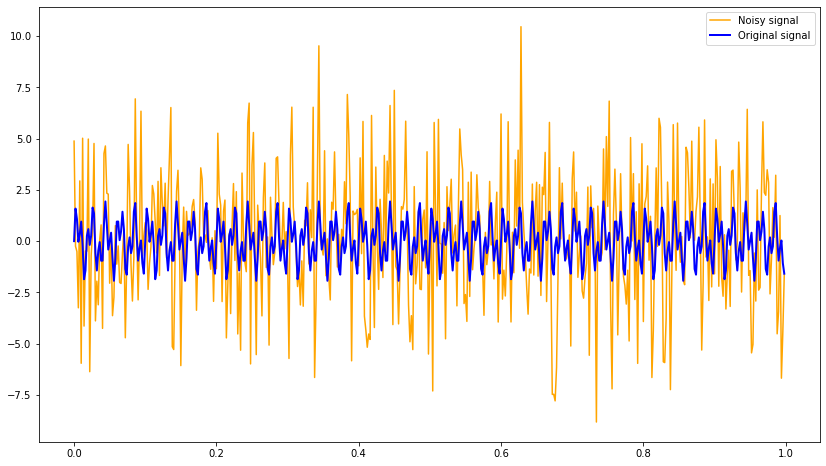

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(t, noisy_signal, color='orange')
plt.plot(t, signal, linewidth=2, color='blue')
plt.legend(('Noisy signal', 'Original signal'))
plt.show()

### FFT transform

In [ ]:
## Compute Fourier Transform

n = len(t)
fhat = np.fft.fft(noisy_signal, n) # computes the fft
psd = fhat * np.conj(fhat)/n # np.conj() returns the complex conjugate of a complex number
freq = (1/(dt*n)) * np.arange(n) # frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) # first half index

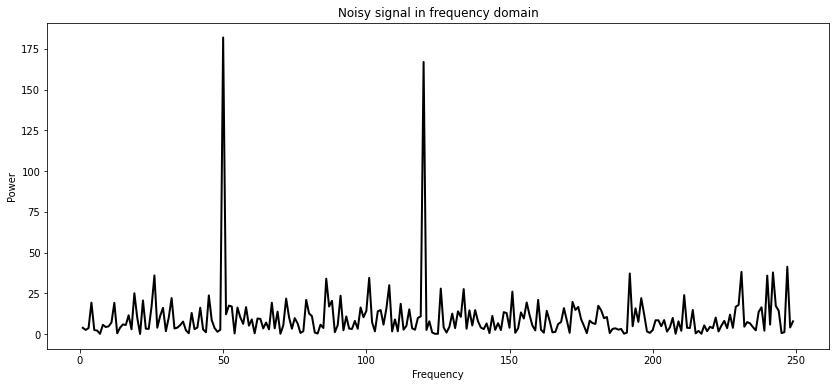

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(freq[idxs_half], np.abs(psd[idxs_half]), color='black', linewidth=2)
plt.title('Noisy signal in frequency domain')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

### Noise filtering

In [ ]:
# we can see that the two frequecies from our original signal is standing out. Now, we can create a filter that can remove all frequencies with amplitude less than our threshold.
threshold = 80
psd_idxs = psd > threshold # array of 0 and 1
psd_clean = psd * psd_idxs # zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat # used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

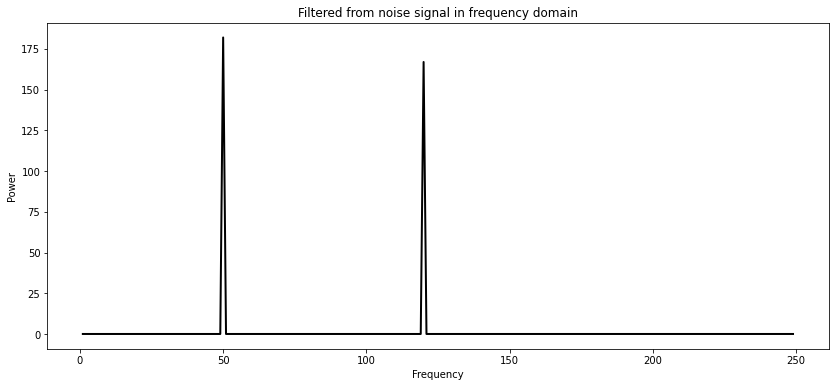

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(freq[idxs_half], np.abs(psd_clean[idxs_half]), color='black', linewidth=2)
plt.title('Filtered from noise signal in frequency domain')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


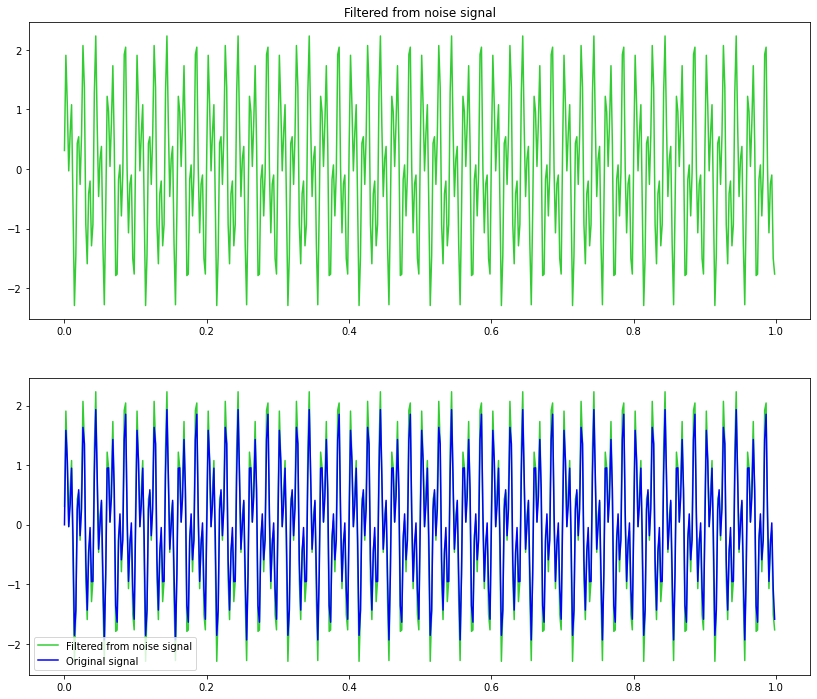

In [ ]:
plt.figure(figsize=(14, 12))

plt.subplot(2, 1, 1)
plt.plot(t, signal_filtered, color='limegreen')
plt.title('Filtered from noise signal')

plt.subplot(2, 1, 2)
plt.plot(t, signal_filtered, color='limegreen')
plt.plot(t, signal, color='blue')
plt.legend(('Filtered from noise signal', 'Original signal'))

plt.show()

# Sound processing and other actions with audio files

In [ ]:
root = '/content/drive/MyDrive/sound_processing_data'

In [ ]:
# how to play audiofile in jupyter notebook

man_voice_file = root + "/sounds/man_voice.wav"
woman_voice_file = root + "/sounds/woman_voice.wav"

In [ ]:
IPython.display.Audio(man_voice_file)

In [ ]:
IPython.display.Audio(woman_voice_file)

## Displaying sound

In [ ]:
# loading audio file

x, sr = librosa.load(man_voice_file)  # returns audio time series (x) and target sampling rate (sr) (22050 by default)

In [ ]:
len(x), sr, len(x) / sr

(189630, 22050, 8.6)

### Waveplot

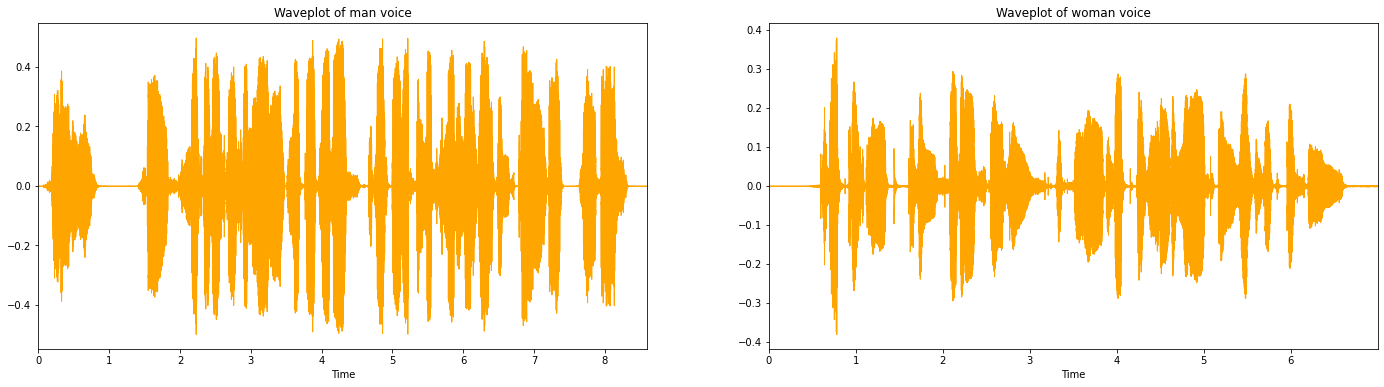

In [ ]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
x, sr = librosa.load(man_voice_file)  # loading audio file
librosa.display.waveplot(x, sr=sr, color='orange')  # displaying the waveplot of audio file
plt.title('Waveplot of man voice')

plt.subplot(1, 2, 2)
x, sr = librosa.load(woman_voice_file)
librosa.display.waveplot(x, sr=sr, color='orange')
plt.title('Waveplot of woman voice')

plt.show()

In [ ]:
def fft_plot(audio, sr, title=''):

    n = len(audio)
    T = 1/sr
    yf = np.fft.fft(audio)
    xf = np.linspace(0.0, 1.0/(2 * T), n//2)

    plt.plot(xf, 2/n * np.abs(yf[:n//2]), color='blue')
    plt.xlabel('Frequency -->')
    plt.ylabel('Magnitude -->')
    plt.title(title)


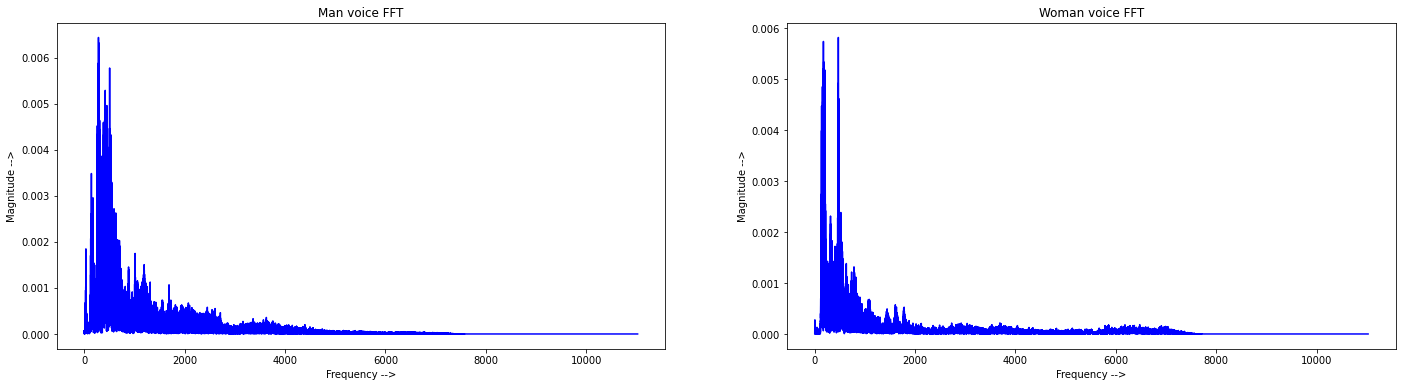

In [ ]:
plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
x, sr = librosa.load(man_voice_file)
fft_plot(x, sr, 'Man voice FFT')

plt.subplot(1, 2, 2)
x, sr = librosa.load(woman_voice_file)
fft_plot(x, sr, 'Woman voice FFT')

plt.show()

### Spectrogram and mel-spectrogram

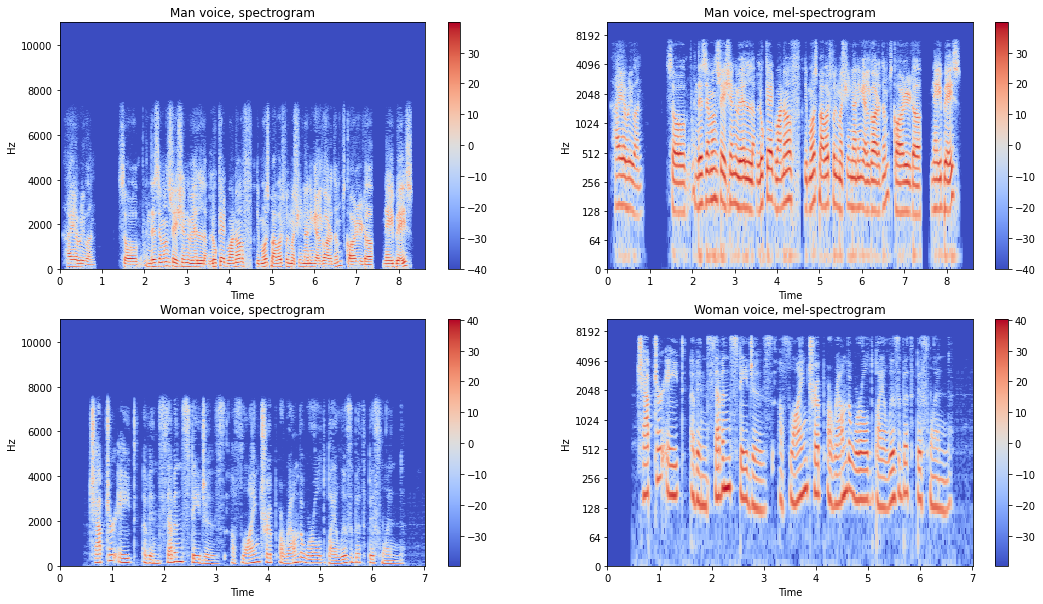

In [ ]:
# generating spectrogram from a signal

plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
x, sr = librosa.load(man_voice_file)  # loading audio file
X = librosa.stft(x) # making Fourier Transform
Xdb = librosa.amplitude_to_db(abs(X)) # "converting" amplitude to decibels
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') # showing simple spectrogram (y_axis='hz')
plt.colorbar()
plt.title('Man voice, spectrogram')

plt.subplot(2, 2, 2)
x, sr = librosa.load(man_voice_file)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log') # showing mel-spectrogram (y_axis='log')
plt.colorbar()
plt.title('Man voice, mel-spectrogram')

plt.subplot(2, 2, 3)
x, sr = librosa.load(woman_voice_file)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title('Woman voice, spectrogram')

plt.subplot(2, 2, 4)
x, sr = librosa.load(woman_voice_file)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.title('Woman voice, mel-spectrogram')

plt.show()

### Chromagram

In [ ]:
sound_440Hz_file = root + '/sounds/sound_440Hz.wav'

In [ ]:
IPython.display.Audio(sound_440Hz_file)

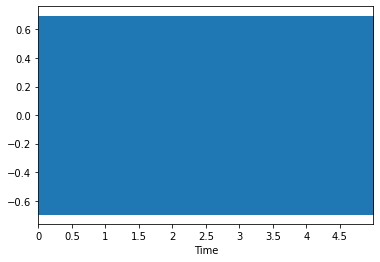

In [ ]:
x, sr = librosa.load(sound_440Hz_file)
librosa.display.waveplot(x, sr=sr)
plt.show()

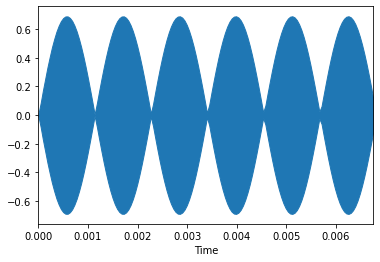

In [ ]:
x, sr = librosa.load(sound_440Hz_file)
librosa.display.waveplot(x[:150], sr=sr)
plt.show()

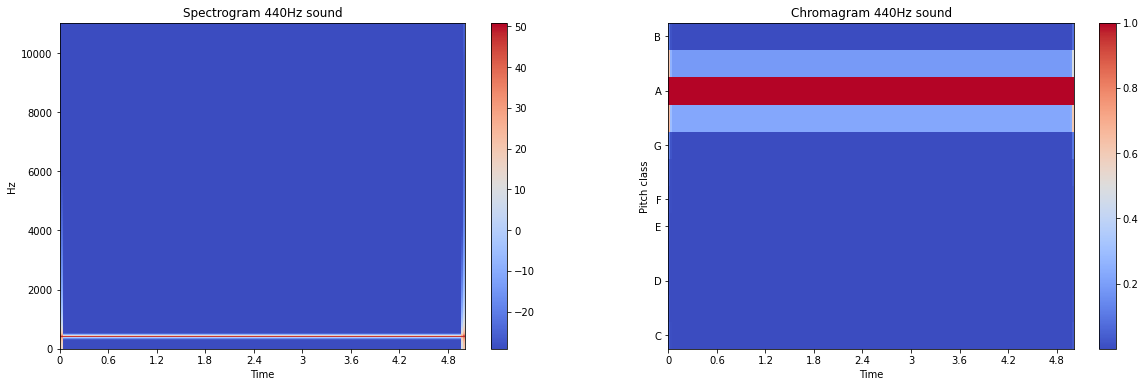

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
x, sr = librosa.load(sound_440Hz_file)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar()
plt.title('Spectrogram 440Hz sound')

plt.subplot(1, 2, 2)
x, sr = librosa.load(sound_440Hz_file)
chromagram = librosa.feature.chroma_stft(x, sr=sr)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chromagram 440Hz sound')

plt.show()

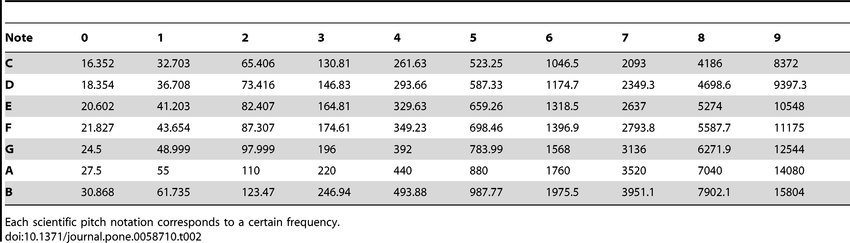

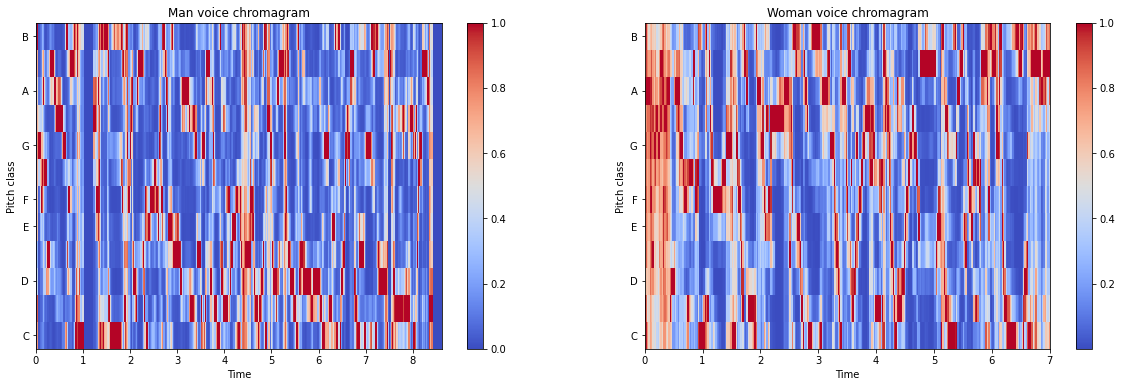

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
x, sr = librosa.load(man_voice_file)
chromagram = librosa.feature.chroma_stft(x, sr=sr)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Man voice chromagram')

plt.subplot(1, 2, 2)
x, sr = librosa.load(woman_voice_file)
chromagram = librosa.feature.chroma_stft(x, sr=sr)
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Woman voice chromagram')

plt.show()

# Neural Networks for sound classification

---



### Training NN on spectrogram images

In [ ]:
train_man_voice_paths = glob(root + '/audio_data/train/man_voice/*.wav')
train_woman_voice_paths = glob(root + '/audio_data/train/woman_voice/*.wav')

test_man_voice_paths = glob(root + '/audio_data/test/man_voice/*.wav')
test_woman_voice_paths = glob(root + '/audio_data/test/woman_voice/*.wav')

In [ ]:
train_man_voice = np.hstack([librosa.load(path)[0] for path in train_man_voice_paths])
train_woman_voice = np.hstack([librosa.load(path)[0] for path in train_woman_voice_paths])
test_man_voice = np.hstack([librosa.load(path)[0] for path in test_man_voice_paths])
test_woman_voice = np.hstack([librosa.load(path)[0] for path in test_woman_voice_paths])

In [ ]:
train_man_voice.shape

(13231416,)

In [ ]:
len(train_man_voice), len(train_woman_voice), len(test_man_voice), len(test_woman_voice)

(13231416, 13224288, 6615708, 6612720)

In [ ]:
len(train_man_voice) / sr, len(train_woman_voice) / sr, len(test_man_voice) / sr, len(test_woman_voice) / sr

(600.0642176870748, 599.7409523809524, 300.0321088435374, 299.89659863945576)

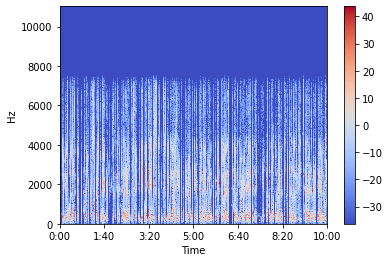

In [ ]:
X = librosa.stft(train_man_voice)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=22050, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar()

In [ ]:
def remove_silent(x):
    org_len = len(x)
    intervals = librosa.effects.split(x, top_db=15, ref= np.max)
    intervals = intervals.tolist()
    x_ns = (x.flatten()).tolist()
    nonsilent_x = []

    for p,q in intervals :
        nonsilent_x = nonsilent_x + x_ns[p:q+1]

    x_ns = np.array(nonsilent_x)

    return x_ns

In [ ]:
train_man_voice_ns = remove_silent(train_man_voice)
train_woman_voice_ns = remove_silent(train_woman_voice)

test_man_voice_ns = remove_silent(test_man_voice)
test_woman_voice_ns = remove_silent(test_woman_voice)

In [ ]:
len(train_man_voice_ns) / sr, len(train_woman_voice_ns) / sr, len(test_man_voice_ns) / sr, len(test_woman_voice_ns) / sr

(301.8059410430839, 338.2999092970522, 147.72272108843538, 180.47097505668935)

In [ ]:
def chunks(arr, chunk_size):

    return  np.array([arr[i:i + chunk_size] for i in range(0, len(arr), chunk_size) if len(arr[i:i + chunk_size]) == chunk_size])

In [ ]:
# 3 seconds of sound = 3 * sr = 3 * 22050 elements of array, sr is sampling rate, sr = 22050

train_man_voice_ns_split = chunks(train_man_voice_ns, 3 * sr)
train_woman_voice_ns_split = chunks(train_woman_voice_ns, 3 * sr)

test_man_voice_ns_split = chunks(test_man_voice_ns, 3 * sr)
test_woman_voice_ns_split = chunks(test_woman_voice_ns, 3 * sr)

In [ ]:
train_man_voice_ns_split.shape

(100, 66150)

In [ ]:
def save_spectrograms_to_directory(chunks, path_to_directory):
    i = 1
    for chunk in chunks:

        X = librosa.stft(chunk)
        Xdb = librosa.amplitude_to_db(abs(X))
        img = librosa.display.specshow(Xdb, sr=22050, x_axis='time', y_axis='log', cmap='binary')
        plt.axis('off')
        plt.savefig(path_to_directory + f'/image_{i}')
        # plt.show()
        # break
        i+=1

In [ ]:
# save_spectrograms_to_directory(train_man_voice_ns_split, root + '/spectrograms/train/man_voice')
# save_spectrograms_to_directory(train_woman_voice_ns_split, root + '/spectrograms/train/woman_voice')

# save_spectrograms_to_directory(test_man_voice_ns_split, root + '/spectrograms/test/man_voice')
# save_spectrograms_to_directory(test_woman_voice_ns_split, root + '/spectrograms/test/woman_voice')

In [ ]:
train_man_paths = glob(root + '/spectrograms/train/man_voice/*.png')
train_woman_paths = glob(root + '/spectrograms/train/woman_voice/*.png')

test_man_paths = glob(root + '/spectrograms/test/man_voice/*.png')
test_woman_paths = glob(root + '/spectrograms/test/woman_voice/*.png')

In [ ]:
train_man_images = [cv2.imread(path, 1) / 255.0 for path in train_man_paths]
train_woman_images = [cv2.imread(path, 1) / 255.0 for path in train_woman_paths]

test_man_images = [cv2.imread(path, 1) / 255.0 for path in test_man_paths]
test_woman_images = [cv2.imread(path, 1) / 255.0 for path in test_woman_paths]

In [ ]:
train_man_labels = [[0]] * len(train_man_images)
train_woman_labels = [[1]] * len(train_woman_images)

test_man_labels = [[0]] * len(test_man_images)
test_woman_labels = [[1]] * len(test_woman_images)

In [ ]:
train_images = np.concatenate((train_man_images, train_woman_images))
test_images = np.concatenate((test_man_images, test_woman_images))

train_labels = np.concatenate((train_man_labels, train_woman_labels))
test_labels = np.concatenate((test_man_labels, test_woman_labels))

In [ ]:
![pitches_frequencies.png]

/bin/bash: [pitches_frequencies.png]: command not found


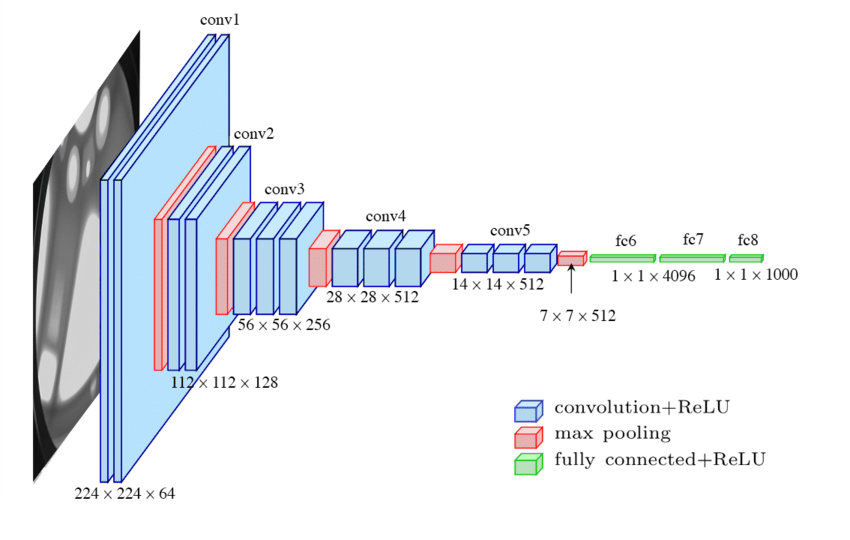

In [ ]:
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)

In [ ]:
# loading already pretrained VGG16 model.

vgg_model = Sequential()

pretrained_model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(288, 432, 3),
    classes=2,
    classifier_activation='sigmoid'
)
for layer in pretrained_model.layers:
        layer.trainable=False

vgg_model.add(pretrained_model)

vgg_model.add(Flatten())
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dense(1, activation='sigmoid'))

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 288, 432, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 288, 432, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 288, 432, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 144, 216, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 144, 216, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 144, 216, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 72, 108, 128)      0     

In [ ]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 13, 512)        14714688  
                                                                 
 flatten (Flatten)           (None, 59904)             0         
                                                                 
 dense (Dense)               (None, 128)               7667840   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22,382,657
Trainable params: 7,667,969
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import Adam
vgg_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = vgg_model.fit(train_images, train_labels, epochs=10, batch_size=16, verbose=1, validation_data=(test_images, test_labels), shuffle=True)

Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 0.6357 - accuracy: 0.8538

KeyboardInterrupt: ignored

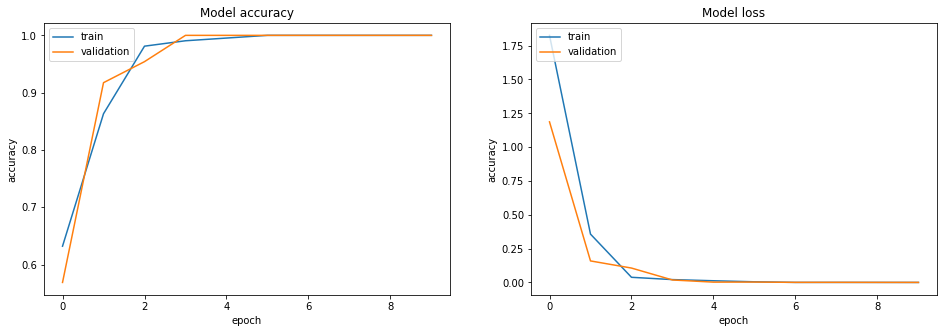

In [ ]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()